In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
#!unzip "/content/drive/MyDrive/covid/daata.zip" -d "/content/drive/MyDrive/covid"

In [3]:
!pip install "torchvision>0.16.0"

In [4]:
import sys
sys.setrecursionlimit(15000)
import torch
import torch.nn.functional as F
from torch import nn
import torch.backends.cudnn as cudnn
from torch.autograd import Variable
import torchvision.models as models

In [5]:
NO_CAPS=3

In [6]:
class StatsNet(nn.Module):
    def __init__(self):
        super(StatsNet, self).__init__()

    def forward(self, x):
        x = x.view(x.data.shape[0], x.data.shape[1], x.data.shape[2]*x.data.shape[3])

        mean = torch.mean(x, 2)
        std = torch.std(x, 2)

        return torch.stack((mean, std), dim=1)

In [7]:
class View(nn.Module):
    def __init__(self, *shape):
        super(View, self).__init__()
        self.shape = shape

    def forward(self, input):
        return input.view(self.shape)

In [8]:
class resExtractor(nn.Module):
    def __init__(self, train=False):
        super(resExtractor, self).__init__()

        self.res_1 = self.res(models.efficientnet_b3(pretrained=True), 0, 3)
        if train:
            self.res_1.train(mode=True)
            self.freeze_gradient()
        else:
            self.res_1.eval()

    def res(self, res, begin, end):
        features = nn.Sequential(*list(res.features.children())[begin:(end+1)])
        return features

    def freeze_gradient(self, begin=0, end=9):
        for i in range(begin, end+1):
            self.res_1[i].requires_grad = False

    def forward(self, input):
        return self.res_1(input)

In [9]:
res_ext = resExtractor()
res_ext

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B3_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


resExtractor(
  (res_1): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 40, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(40, 40, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=40, bias=False)
            (1): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(40, 10, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(10, 40, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivati

In [10]:
class FeatureExtractor(nn.Module):
    def __init__(self):
        super(FeatureExtractor, self).__init__()

        self.capsules = nn.ModuleList([
            nn.Sequential(
                nn.Conv2d(48, 64, kernel_size=3, stride=1, padding=1),
                nn.BatchNorm2d(64),
                nn.ReLU(),
                nn.Conv2d(64, 16, kernel_size=3, stride=1, padding=1),
                nn.BatchNorm2d(16),
                nn.ReLU(),
                StatsNet(),

                nn.Conv1d(2, 8, kernel_size=5, stride=2, padding=2),
                nn.BatchNorm1d(8),
                nn.Conv1d(8, 1, kernel_size=3, stride=1, padding=1),
                nn.BatchNorm1d(1),
                View(-1, 8),
                )
                for _ in range(NO_CAPS)]
        )

    def squash(self, tensor, dim):
        squared_norm = (tensor ** 2).sum(dim=dim, keepdim=True)
        scale = squared_norm / (1 + squared_norm)
        return scale * tensor / (torch.sqrt(squared_norm))

    def forward(self, x):
        # outputs = [capsule(x.detach()) for capsule in self.capsules]
        # outputs = [capsule(x.clone()) for capsule in self.capsules]
        outputs = [capsule(x) for capsule in self.capsules]
        output = torch.stack(outputs, dim=-1)

        return self.squash(output, dim=-1)

In [11]:
class RoutingLayer(nn.Module):
    def __init__(self, gpu_id, num_input_capsules, num_output_capsules, data_in, data_out, num_iterations):
        super(RoutingLayer, self).__init__()

        self.gpu_id = gpu_id
        self.num_iterations = num_iterations
        self.route_weights = nn.Parameter(torch.randn(num_output_capsules, num_input_capsules, data_out, data_in))


    def squash(self, tensor, dim):
        squared_norm = (tensor ** 2).sum(dim=dim, keepdim=True)
        scale = squared_norm / (1 + squared_norm)
        return scale * tensor / (torch.sqrt(squared_norm))

    def forward(self, x, random, dropout):
        # x[b, data, in_caps]

        x = x.transpose(2, 1)
        # x[b, in_caps, data]

        if random:
            noise = Variable(0.01*torch.randn(*self.route_weights.size()))
            if self.gpu_id >= 0:
                noise = noise.cuda(self.gpu_id)
            route_weights = self.route_weights + noise
        else:
            route_weights = self.route_weights

        priors = route_weights[:, None, :, :, :] @ x[None, :, :, :, None]

        # route_weights [out_caps , 1 , in_caps , data_out , data_in]
        # x             [   1     , b , in_caps , data_in ,    1    ]
        # priors        [out_caps , b , in_caps , data_out,    1    ]

        priors = priors.transpose(1, 0)
        # priors[b, out_caps, in_caps, data_out, 1]

        if dropout > 0.0:
            drop = Variable(torch.FloatTensor(*priors.size()).bernoulli(1.0- dropout))
            if self.gpu_id >= 0:
                drop = drop.cuda(self.gpu_id)
            priors = priors * drop


        logits = Variable(torch.zeros(*priors.size()))
        # logits[b, out_caps, in_caps, data_out, 1]

        if self.gpu_id >= 0:
            logits = logits.cuda(self.gpu_id)

        num_iterations = self.num_iterations

        for i in range(num_iterations):
            probs = F.softmax(logits, dim=2)
            outputs = self.squash((probs * priors).sum(dim=2, keepdim=True), dim=3)

            if i != self.num_iterations - 1:
                delta_logits = priors * outputs
                logits = logits + delta_logits

        # outputs[b, out_caps, 1, data_out, 1]
        outputs = outputs.squeeze()

        if len(outputs.shape) == 3:
            outputs = outputs.transpose(2, 1).contiguous()
        else:
            outputs = outputs.unsqueeze_(dim=0).transpose(2, 1).contiguous()
        # outputs[b, data_out, out_caps]

        return outputs

In [12]:
class CapsuleNet(nn.Module):
    def __init__(self, num_class, gpu_id):
        super(CapsuleNet, self).__init__()

        self.num_class = num_class
        self.fea_ext = FeatureExtractor()
        self.fea_ext.apply(self.weights_init)

        self.routing_stats = RoutingLayer(gpu_id=gpu_id, num_input_capsules=NO_CAPS, num_output_capsules=num_class, data_in=8, data_out=4, num_iterations=2)

    def weights_init(self, m):
        classname = m.__class__.__name__
        if classname.find('Conv') != -1:
            m.weight.data.normal_(0.0, 0.02)
        elif classname.find('BatchNorm') != -1:
            m.weight.data.normal_(1.0, 0.02)
            m.bias.data.fill_(0)

    def forward(self, x, random=False, dropout=0.0):

        z = self.fea_ext(x)
        z = self.routing_stats(z, random, dropout=dropout)
        # z[b, data, out_caps]

        # classes = F.softmax(z, dim=-1)

        # class_ = classes.detach()
        # class_ = class_.mean(dim=1)

        # return classes, class_

        classes = F.softmax(z, dim=-1)
        class_ = classes.detach()
        class_ = class_.mean(dim=1)

        return z, class_

In [13]:
class CapsuleLoss(nn.Module):
    def __init__(self, gpu_id):
        super(CapsuleLoss, self).__init__()
        self.cross_entropy_loss = nn.CrossEntropyLoss()

        if gpu_id >= 0:
            self.cross_entropy_loss.cuda(gpu_id)

    def forward(self, classes, labels):
        # abc = F.tanh(classes[:,0,0])
        # labels[labels == 0] = -1
        loss_t = self.cross_entropy_loss(classes[:,0,:], labels)

        for i in range(classes.size(1) - 1):
            loss_t = loss_t + self.cross_entropy_loss(classes[:,i+1,:], labels)

        return loss_t

In [14]:
import sys
sys.setrecursionlimit(15000)
import os
import random
import torch
import torch.backends.cudnn as cudnn
import numpy as np
from torch.autograd import Variable
from torch.optim import Adam
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
from tqdm import tqdm
from sklearn import metrics

In [15]:
import warnings
warnings.filterwarnings("ignore")

In [16]:
manualSeed = None
gpu_id = 0
#choose a epochs to resume from (0 to train from scratch)
resume = 0
#folder to output model checkpoints
outf = "/content/drive/MyDrive/covid/multi/"
#beta1 for adam
beta1 = 0.9
#learning rate
lr = 0.0005
#path to root dataset
dataset = "/content/drive/MyDrive/covid/multi/output"
train_set = "train"
val_set = "val"
#number of data loading workers
workers = 0
batchSize = 32 #default = 32
#the height / width of the input image to network
imageSize = 256
#number of epochs to train for
niter = 25
#disable randomness for routing matrix
disable_random = False
#dropout percentage
dropout= 0.05

In [17]:
if manualSeed is None:
    manualSeed = random.randint(1, 10000)
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

Random Seed:  6522


In [18]:
if gpu_id >= 0:
    torch.cuda.manual_seed_all(manualSeed)
    cudnn.benchmark = True

In [19]:
if resume > 0:
    text_writer = open(os.path.join(outf, 'train.csv'), 'a')
else:
    text_writer = open(os.path.join(outf, 'train.csv'), 'w')

In [20]:
res_ext = resExtractor()
capnet = CapsuleNet(2, gpu_id)
capsule_loss = CapsuleLoss(gpu_id)

In [21]:
optimizer = Adam(capnet.parameters(), lr=lr, betas=(beta1, 0.999))

In [22]:
if resume > 0:
    capnet.load_state_dict(torch.load(os.path.join(outf,'capsule_' + str(resume) + '.pt')))
    capnet.train(mode=True)
    optimizer.load_state_dict(torch.load(os.path.join(outf,'optim_' + str(resume) + '.pt')))

    if gpu_id >= 0:
        for state in optimizer.state.values():
            for k, v in state.items():
                if isinstance(v, torch.Tensor):
                    state[k] = v.cuda(gpu_id)


In [23]:
if gpu_id >= 0:
    capnet.cuda(gpu_id)
    res_ext.cuda(gpu_id)
    capsule_loss.cuda(gpu_id)

In [24]:
transform_fwd = transforms.Compose([
    transforms.Resize((imageSize, imageSize)),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
])

In [25]:
dataset_train = dset.ImageFolder(root=os.path.join(dataset, train_set), transform=transform_fwd)
assert dataset_train
dataloader_train = torch.utils.data.DataLoader(dataset_train, batch_size=batchSize, shuffle=True, num_workers=int(workers))

In [26]:
dataset_val = dset.ImageFolder(root=os.path.join(dataset, val_set), transform=transform_fwd)
assert dataset_val
dataloader_val = torch.utils.data.DataLoader(dataset_val, batch_size=batchSize, shuffle=False, num_workers=int(workers))

In [27]:
for epoch in range(resume+1, niter+1):
    count = 0
    loss_train = 0
    loss_test = 0

    tol_label = np.array([], dtype=float)
    tol_pred = np.array([], dtype=float)

    for img_data, labels_data in tqdm(dataloader_train):

        labels_data[labels_data > 1] = 1
        img_label = labels_data.numpy().astype(float)
        optimizer.zero_grad()

        if gpu_id >= 0:
            img_data = img_data.cuda(gpu_id)
            labels_data = labels_data.cuda(gpu_id)

        input_v = Variable(img_data)
        x = res_ext(input_v)
        classes, class_ = capnet(x, random=random, dropout=dropout)

        loss_dis = capsule_loss(classes, Variable(labels_data, requires_grad=False))
        loss_dis_data = loss_dis.item()

        loss_dis.backward()
        optimizer.step()

        output_dis = class_.data.cpu().numpy()
        output_pred = np.zeros((output_dis.shape[0]), dtype=float)

        for i in range(output_dis.shape[0]):
            if output_dis[i,1] >= output_dis[i,0]:
                output_pred[i] = 1.0
            else:
                output_pred[i] = 0.0

        tol_label = np.concatenate((tol_label, img_label))
        tol_pred = np.concatenate((tol_pred, output_pred))

        loss_train += loss_dis_data
        count += 1


    acc_train = metrics.accuracy_score(tol_label, tol_pred)
    prec_train = metrics.precision_score(tol_label, tol_pred)
    rec_train = metrics.recall_score(tol_label, tol_pred)
    f1_train = metrics.f1_score(tol_label, tol_pred)
    loss_train /= count

    ########################################################################

    # do checkpointing & validation
    torch.save(capnet.state_dict(), os.path.join(outf, 'capsule_%d.pt' % epoch))
    torch.save(optimizer.state_dict(), os.path.join(outf, 'optim_%d.pt' % epoch))

    capnet.eval()

    tol_label = np.array([], dtype=float)
    tol_pred = np.array([], dtype=float)

    count = 0

    for img_data, labels_data in dataloader_val:

        labels_data[labels_data > 1] = 1
        img_label = labels_data.numpy().astype(float)

        if gpu_id >= 0:
            img_data = img_data.cuda(gpu_id)
            labels_data = labels_data.cuda(gpu_id)

        input_v = Variable(img_data)

        x = res_ext(input_v)
        classes, class_ = capnet(x, random=False)

        loss_dis = capsule_loss(classes, Variable(labels_data, requires_grad=False))
        loss_dis_data = loss_dis.item()
        output_dis = class_.data.cpu().numpy()

        output_pred = np.zeros((output_dis.shape[0]), dtype=float)

        for i in range(output_dis.shape[0]):
            if output_dis[i,1] >= output_dis[i,0]:
                output_pred[i] = 1.0
            else:
                output_pred[i] = 0.0

        tol_label = np.concatenate((tol_label, img_label))
        tol_pred = np.concatenate((tol_pred, output_pred))

        loss_test += loss_dis_data
        count += 1

    acc_test = metrics.accuracy_score(tol_label, tol_pred)
    prec_test = metrics.precision_score(tol_label, tol_pred)
    rec_test = metrics.recall_score(tol_label, tol_pred)
    f1_test = metrics.f1_score(tol_label, tol_pred)
    loss_test /= count

    print('[Epoch %d] Train loss: %.4f   acc: %.2f | Test loss: %.4f  acc: %.2f'
    % (epoch, loss_train, acc_train*100, loss_test, acc_test*100))
    print('[Epoch %d] Train loss: %.4f   prec: %.2f | Test loss: %.4f  prec: %.2f'
    % (epoch, loss_train, prec_train*100, loss_test, prec_test*100))
    print('[Epoch %d] Train loss: %.4f   rec: %.2f | Test loss: %.4f  rec: %.2f'
    % (epoch, loss_train, rec_train*100, loss_test, rec_test*100))
    print('[Epoch %d] Train loss: %.4f   f1: %.2f | Test loss: %.4f  f1: %.2f'
    % (epoch, loss_train, f1_train*100, loss_test, f1_test*100))

    #text_writer.write('%d,%.4f,%.2f,%.4f,%.2f\n'
    #% (epoch, loss_train, acc_train*100, loss_test, acc_test*100))

    #text_writer.flush()
    capnet.train(mode=True)

text_writer.close()

100%|██████████| 38/38 [00:40<00:00,  1.05s/it]


[Epoch 1] Train loss: 1.8063   acc: 93.54 | Test loss: 2.7341  acc: 94.38
[Epoch 1] Train loss: 1.8063   prec: 97.79 | Test loss: 2.7341  prec: 93.03
[Epoch 1] Train loss: 1.8063   rec: 93.56 | Test loss: 2.7341  rec: 100.00
[Epoch 1] Train loss: 1.8063   f1: 95.63 | Test loss: 2.7341  f1: 96.39


100%|██████████| 38/38 [00:34<00:00,  1.11it/s]


[Epoch 2] Train loss: 1.5099   acc: 98.32 | Test loss: 1.5988  acc: 98.64
[Epoch 2] Train loss: 1.5099   prec: 98.67 | Test loss: 1.5988  prec: 98.72
[Epoch 2] Train loss: 1.5099   rec: 99.11 | Test loss: 1.5988  rec: 99.48
[Epoch 2] Train loss: 1.5099   f1: 98.89 | Test loss: 1.5988  f1: 99.10


100%|██████████| 38/38 [00:34<00:00,  1.11it/s]


[Epoch 3] Train loss: 1.4622   acc: 99.33 | Test loss: 1.4262  acc: 99.42
[Epoch 3] Train loss: 1.4622   prec: 99.34 | Test loss: 1.4262  prec: 99.48
[Epoch 3] Train loss: 1.4622   rec: 99.78 | Test loss: 1.4262  rec: 99.74
[Epoch 3] Train loss: 1.4622   f1: 99.56 | Test loss: 1.4262  f1: 99.61


100%|██████████| 38/38 [00:33<00:00,  1.12it/s]


[Epoch 4] Train loss: 1.4410   acc: 99.33 | Test loss: 1.4107  acc: 99.42
[Epoch 4] Train loss: 1.4410   prec: 99.34 | Test loss: 1.4107  prec: 99.48
[Epoch 4] Train loss: 1.4410   rec: 99.78 | Test loss: 1.4107  rec: 99.74
[Epoch 4] Train loss: 1.4410   f1: 99.56 | Test loss: 1.4107  f1: 99.61


100%|██████████| 38/38 [00:33<00:00,  1.12it/s]


[Epoch 5] Train loss: 1.4278   acc: 99.58 | Test loss: 1.3967  acc: 99.61
[Epoch 5] Train loss: 1.4278   prec: 99.56 | Test loss: 1.3967  prec: 99.74
[Epoch 5] Train loss: 1.4278   rec: 99.89 | Test loss: 1.3967  rec: 99.74
[Epoch 5] Train loss: 1.4278   f1: 99.72 | Test loss: 1.3967  f1: 99.74


100%|██████████| 38/38 [00:33<00:00,  1.12it/s]


[Epoch 6] Train loss: 1.4050   acc: 99.66 | Test loss: 1.3900  acc: 99.42
[Epoch 6] Train loss: 1.4050   prec: 99.56 | Test loss: 1.3900  prec: 99.48
[Epoch 6] Train loss: 1.4050   rec: 100.00 | Test loss: 1.3900  rec: 99.74
[Epoch 6] Train loss: 1.4050   f1: 99.78 | Test loss: 1.3900  f1: 99.61


100%|██████████| 38/38 [00:33<00:00,  1.13it/s]


[Epoch 7] Train loss: 1.3912   acc: 99.75 | Test loss: 1.3775  acc: 99.42
[Epoch 7] Train loss: 1.3912   prec: 99.67 | Test loss: 1.3775  prec: 99.48
[Epoch 7] Train loss: 1.3912   rec: 100.00 | Test loss: 1.3775  rec: 99.74
[Epoch 7] Train loss: 1.3912   f1: 99.83 | Test loss: 1.3775  f1: 99.61


100%|██████████| 38/38 [00:33<00:00,  1.13it/s]


[Epoch 8] Train loss: 1.3878   acc: 99.83 | Test loss: 1.3794  acc: 99.61
[Epoch 8] Train loss: 1.3878   prec: 99.78 | Test loss: 1.3794  prec: 99.74
[Epoch 8] Train loss: 1.3878   rec: 100.00 | Test loss: 1.3794  rec: 99.74
[Epoch 8] Train loss: 1.3878   f1: 99.89 | Test loss: 1.3794  f1: 99.74


100%|██████████| 38/38 [00:33<00:00,  1.13it/s]


[Epoch 9] Train loss: 1.3738   acc: 99.83 | Test loss: 1.3595  acc: 99.61
[Epoch 9] Train loss: 1.3738   prec: 99.78 | Test loss: 1.3595  prec: 99.74
[Epoch 9] Train loss: 1.3738   rec: 100.00 | Test loss: 1.3595  rec: 99.74
[Epoch 9] Train loss: 1.3738   f1: 99.89 | Test loss: 1.3595  f1: 99.74


100%|██████████| 38/38 [00:33<00:00,  1.14it/s]


[Epoch 10] Train loss: 1.3741   acc: 99.83 | Test loss: 1.3498  acc: 99.61
[Epoch 10] Train loss: 1.3741   prec: 99.78 | Test loss: 1.3498  prec: 99.74
[Epoch 10] Train loss: 1.3741   rec: 100.00 | Test loss: 1.3498  rec: 99.74
[Epoch 10] Train loss: 1.3741   f1: 99.89 | Test loss: 1.3498  f1: 99.74


100%|██████████| 38/38 [00:33<00:00,  1.13it/s]


[Epoch 11] Train loss: 1.3646   acc: 99.83 | Test loss: 1.3564  acc: 99.42
[Epoch 11] Train loss: 1.3646   prec: 99.78 | Test loss: 1.3564  prec: 99.48
[Epoch 11] Train loss: 1.3646   rec: 100.00 | Test loss: 1.3564  rec: 99.74
[Epoch 11] Train loss: 1.3646   f1: 99.89 | Test loss: 1.3564  f1: 99.61


100%|██████████| 38/38 [00:33<00:00,  1.13it/s]


[Epoch 12] Train loss: 1.3653   acc: 99.92 | Test loss: 1.4019  acc: 99.61
[Epoch 12] Train loss: 1.3653   prec: 99.89 | Test loss: 1.4019  prec: 100.00
[Epoch 12] Train loss: 1.3653   rec: 100.00 | Test loss: 1.4019  rec: 99.48
[Epoch 12] Train loss: 1.3653   f1: 99.94 | Test loss: 1.4019  f1: 99.74


100%|██████████| 38/38 [00:33<00:00,  1.13it/s]


[Epoch 13] Train loss: 1.3782   acc: 99.92 | Test loss: 1.3857  acc: 98.84
[Epoch 13] Train loss: 1.3782   prec: 99.89 | Test loss: 1.3857  prec: 98.72
[Epoch 13] Train loss: 1.3782   rec: 100.00 | Test loss: 1.3857  rec: 99.74
[Epoch 13] Train loss: 1.3782   f1: 99.94 | Test loss: 1.3857  f1: 99.23


100%|██████████| 38/38 [00:33<00:00,  1.13it/s]


[Epoch 14] Train loss: 1.3548   acc: 99.92 | Test loss: 1.3391  acc: 99.81
[Epoch 14] Train loss: 1.3548   prec: 99.89 | Test loss: 1.3391  prec: 100.00
[Epoch 14] Train loss: 1.3548   rec: 100.00 | Test loss: 1.3391  rec: 99.74
[Epoch 14] Train loss: 1.3548   f1: 99.94 | Test loss: 1.3391  f1: 99.87


100%|██████████| 38/38 [00:33<00:00,  1.14it/s]


[Epoch 15] Train loss: 1.3527   acc: 99.92 | Test loss: 1.3334  acc: 99.81
[Epoch 15] Train loss: 1.3527   prec: 99.89 | Test loss: 1.3334  prec: 100.00
[Epoch 15] Train loss: 1.3527   rec: 100.00 | Test loss: 1.3334  rec: 99.74
[Epoch 15] Train loss: 1.3527   f1: 99.94 | Test loss: 1.3334  f1: 99.87


100%|██████████| 38/38 [00:33<00:00,  1.13it/s]


[Epoch 16] Train loss: 1.3396   acc: 99.92 | Test loss: 1.3256  acc: 99.81
[Epoch 16] Train loss: 1.3396   prec: 99.89 | Test loss: 1.3256  prec: 100.00
[Epoch 16] Train loss: 1.3396   rec: 100.00 | Test loss: 1.3256  rec: 99.74
[Epoch 16] Train loss: 1.3396   f1: 99.94 | Test loss: 1.3256  f1: 99.87


100%|██████████| 38/38 [00:34<00:00,  1.11it/s]


[Epoch 17] Train loss: 1.3372   acc: 100.00 | Test loss: 1.3208  acc: 99.81
[Epoch 17] Train loss: 1.3372   prec: 100.00 | Test loss: 1.3208  prec: 100.00
[Epoch 17] Train loss: 1.3372   rec: 100.00 | Test loss: 1.3208  rec: 99.74
[Epoch 17] Train loss: 1.3372   f1: 100.00 | Test loss: 1.3208  f1: 99.87


100%|██████████| 38/38 [00:33<00:00,  1.12it/s]


[Epoch 18] Train loss: 1.3316   acc: 100.00 | Test loss: 1.3227  acc: 99.81
[Epoch 18] Train loss: 1.3316   prec: 100.00 | Test loss: 1.3227  prec: 100.00
[Epoch 18] Train loss: 1.3316   rec: 100.00 | Test loss: 1.3227  rec: 99.74
[Epoch 18] Train loss: 1.3316   f1: 100.00 | Test loss: 1.3227  f1: 99.87


100%|██████████| 38/38 [00:34<00:00,  1.11it/s]


[Epoch 19] Train loss: 1.3280   acc: 100.00 | Test loss: 1.3197  acc: 99.81
[Epoch 19] Train loss: 1.3280   prec: 100.00 | Test loss: 1.3197  prec: 100.00
[Epoch 19] Train loss: 1.3280   rec: 100.00 | Test loss: 1.3197  rec: 99.74
[Epoch 19] Train loss: 1.3280   f1: 100.00 | Test loss: 1.3197  f1: 99.87


100%|██████████| 38/38 [00:34<00:00,  1.11it/s]


[Epoch 20] Train loss: 1.3262   acc: 100.00 | Test loss: 1.3105  acc: 99.81
[Epoch 20] Train loss: 1.3262   prec: 100.00 | Test loss: 1.3105  prec: 100.00
[Epoch 20] Train loss: 1.3262   rec: 100.00 | Test loss: 1.3105  rec: 99.74
[Epoch 20] Train loss: 1.3262   f1: 100.00 | Test loss: 1.3105  f1: 99.87


100%|██████████| 38/38 [00:34<00:00,  1.11it/s]


[Epoch 21] Train loss: 1.3235   acc: 100.00 | Test loss: 1.3160  acc: 99.81
[Epoch 21] Train loss: 1.3235   prec: 100.00 | Test loss: 1.3160  prec: 100.00
[Epoch 21] Train loss: 1.3235   rec: 100.00 | Test loss: 1.3160  rec: 99.74
[Epoch 21] Train loss: 1.3235   f1: 100.00 | Test loss: 1.3160  f1: 99.87


100%|██████████| 38/38 [00:34<00:00,  1.11it/s]


[Epoch 22] Train loss: 1.3209   acc: 100.00 | Test loss: 1.3099  acc: 99.81
[Epoch 22] Train loss: 1.3209   prec: 100.00 | Test loss: 1.3099  prec: 100.00
[Epoch 22] Train loss: 1.3209   rec: 100.00 | Test loss: 1.3099  rec: 99.74
[Epoch 22] Train loss: 1.3209   f1: 100.00 | Test loss: 1.3099  f1: 99.87


100%|██████████| 38/38 [00:33<00:00,  1.12it/s]


[Epoch 23] Train loss: 1.3180   acc: 100.00 | Test loss: 1.3113  acc: 99.81
[Epoch 23] Train loss: 1.3180   prec: 100.00 | Test loss: 1.3113  prec: 100.00
[Epoch 23] Train loss: 1.3180   rec: 100.00 | Test loss: 1.3113  rec: 99.74
[Epoch 23] Train loss: 1.3180   f1: 100.00 | Test loss: 1.3113  f1: 99.87


100%|██████████| 38/38 [00:33<00:00,  1.13it/s]


[Epoch 24] Train loss: 1.3211   acc: 100.00 | Test loss: 1.3142  acc: 99.81
[Epoch 24] Train loss: 1.3211   prec: 100.00 | Test loss: 1.3142  prec: 100.00
[Epoch 24] Train loss: 1.3211   rec: 100.00 | Test loss: 1.3142  rec: 99.74
[Epoch 24] Train loss: 1.3211   f1: 100.00 | Test loss: 1.3142  f1: 99.87


100%|██████████| 38/38 [00:33<00:00,  1.13it/s]


[Epoch 25] Train loss: 1.3163   acc: 100.00 | Test loss: 1.3111  acc: 99.81
[Epoch 25] Train loss: 1.3163   prec: 100.00 | Test loss: 1.3111  prec: 100.00
[Epoch 25] Train loss: 1.3163   rec: 100.00 | Test loss: 1.3111  rec: 99.74
[Epoch 25] Train loss: 1.3163   f1: 100.00 | Test loss: 1.3111  f1: 99.87


In [62]:
ML_Model = []
accuracy = []
precision = []
recall = []
f1score = []

#function to call for storing the results
def storeResults(model, a,b,c,d):
    ML_Model.append(model)
    accuracy.append(round(a, 3))
    precision.append(round(b, 3))
    recall.append(round(c, 3))
    f1score.append(round(d, 3))

In [63]:
dl_acc = 99.81
dl_prec = 100.00
dl_rec = 99.74
dl_f1 = 99.87

storeResults('ResCapsNet',dl_acc,dl_prec,dl_rec,dl_f1)

DCNN Models

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
from tensorflow.keras.layers import Dense, Flatten, Input, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from keras.models import Sequential
from glob import glob
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

In [3]:
from tensorflow.keras.applications import DenseNet121, ResNet101, VGG19

In [4]:
train_path = "multi/output/train"
test_path = "multi/output/val"

In [5]:
IMAGE_SIZE = [128,128]

In [6]:
# Scaling all the images between 0 to 1

train_datagen = ImageDataGenerator(rescale = 1./255, shear_range=0.2, zoom_range=0.2, horizontal_flip=False)

# Performing only scaling on the test dataset

test_datagen = ImageDataGenerator(rescale=1./255)

In [7]:
train_set = train_datagen.flow_from_directory(train_path,
                                              target_size=(128,128),
                                              batch_size=2,
                                              class_mode = 'categorical')

test_set = test_datagen.flow_from_directory(test_path,
                                            target_size=(128,128),
                                            batch_size=2,
                                            class_mode='categorical')

Found 1192 images belonging to 3 classes.
Found 516 images belonging to 3 classes.


In [8]:
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [9]:
from keras.metrics import Precision, Recall
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import Sequential, Model

learning_rate_reduction = ReduceLROnPlateau(
    monitor="val_accuracy", patience=3, verbose=1, factor=0.3, min_lr=0.0000001
)
early_stop = EarlyStopping(
    patience=10,
    verbose=1,
    monitor="val_accuracy",
    mode="max",
    min_delta=0.001,
    restore_best_weights=True,
)

# CNN

In [10]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense, MaxPool2D, Dropout, Flatten
from tensorflow.keras.optimizers import Adam

In [49]:
model1 = Sequential()
model1.add(Conv2D(filters=32, kernel_size=(5,5), padding='same', activation='relu', input_shape=(128, 128, 3)))
model1.add(MaxPool2D(strides=2))
model1.add(Conv2D(filters=48, kernel_size=(5,5), padding='valid', activation='relu'))
model1.add(MaxPool2D(strides=2))
model1.add(Flatten())
model1.add(Dense(256, activation='relu'))
model1.add(Dense(84, activation='relu'))
model1.add(Dense(3, activation='softmax'))

In [50]:
model1.summary()
model1.compile(loss = 'categorical_crossentropy', optimizer='adam', metrics=["accuracy",f1_m,precision_m, recall_m])

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 128, 128, 32)      2432      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 60, 60, 48)        38448     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 30, 30, 48)        0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 43200)             0         
_________________________________________________________________
dense_7 (Dense)              (None, 256)               11059456  
_________________________________________________________________
dense_8 (Dense)              (None, 84)               

In [51]:
hist1 = model1.fit(train_set, validation_data=test_set, epochs=25, steps_per_epoch=len(train_set), validation_steps=len(test_set),callbacks=[learning_rate_reduction, early_stop])

Epoch 1/25
596/596 [==============================] - 17s 28ms/step - loss: 0.9879 - accuracy: 0.5319 - f1_m: 0.3521 - precision_m: 0.4354 - recall_m: 0.3104 - val_loss: 0.5465 - val_accuracy: 0.7578 - val_f1_m: 0.7455 - val_precision_m: 0.7946 - val_recall_m: 0.7209
Epoch 2/25
596/596 [==============================] - 16s 27ms/step - loss: 0.6286 - accuracy: 0.7441 - f1_m: 0.7190 - precision_m: 0.7659 - recall_m: 0.6955 - val_loss: 0.4345 - val_accuracy: 0.8469 - val_f1_m: 0.8191 - val_precision_m: 0.8566 - val_recall_m: 0.8004
Epoch 3/25
596/596 [==============================] - 16s 27ms/step - loss: 0.4717 - accuracy: 0.8154 - f1_m: 0.8012 - precision_m: 0.8314 - recall_m: 0.7861 - val_loss: 0.4730 - val_accuracy: 0.8178 - val_f1_m: 0.8178 - val_precision_m: 0.8256 - val_recall_m: 0.8140
Epoch 4/25
596/596 [==============================] - 16s 28ms/step - loss: 0.4604 - accuracy: 0.8289 - f1_m: 0.8249 - precision_m: 0.8456 - recall_m: 0.8146 - val_loss: 0.3618 - val_accuracy: 0.8

In [64]:
dl_acc = hist1.history["val_accuracy"][24] * 100
dl_prec = hist1.history["val_precision_m"][24] * 100
dl_rec = hist1.history["val_recall_m"][24] * 100
dl_f1 = hist1.history["val_f1_m"][24] * 100

storeResults('CNN',dl_acc,dl_prec,dl_rec,dl_f1)

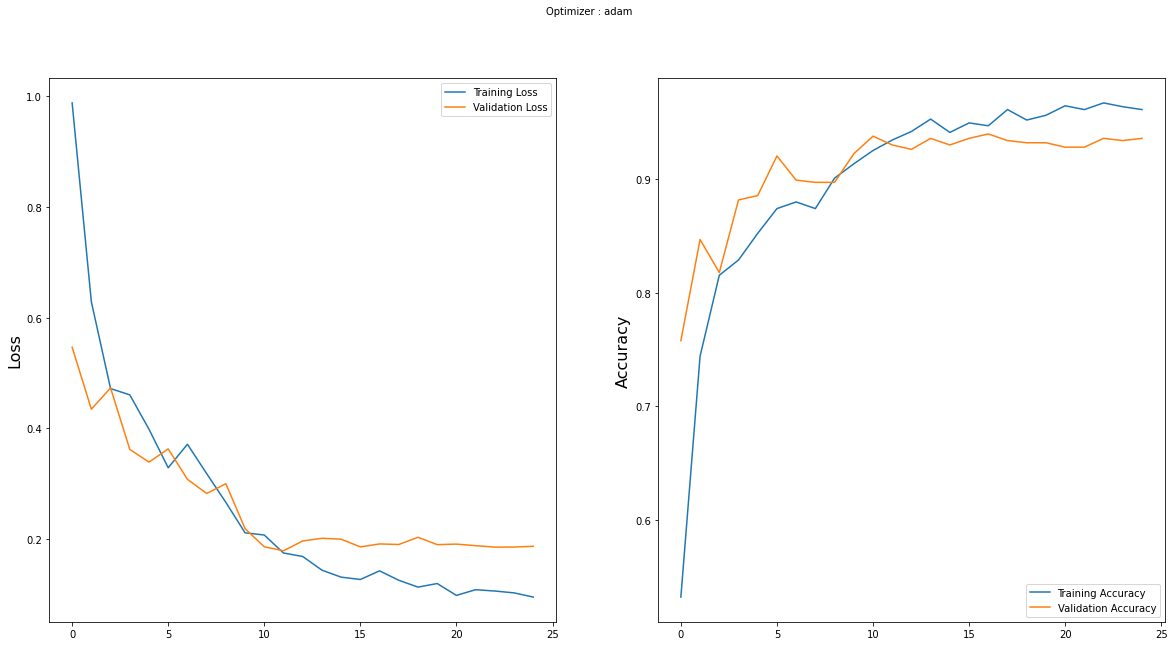

In [52]:
import matplotlib.pyplot as plt

x=hist1
plt.figure(figsize=(20,10))
plt.subplot(1, 2, 1)
plt.suptitle('Optimizer : adam', fontsize=10)
plt.ylabel('Loss', fontsize=16)
plt.plot(x.history['loss'], label='Training Loss')
plt.plot(x.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')

plt.subplot(1, 2, 2)
plt.ylabel('Accuracy', fontsize=16)
plt.plot(x.history['accuracy'], label='Training Accuracy')
plt.plot(x.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.show()

# VGG19

In [53]:
base_model = VGG19(input_shape = IMAGE_SIZE + [3], weights='imagenet', include_top=False)

x1= Flatten()(base_model.output)
prediction1 = Dense(3, activation='softmax')(x1)
model2 = Model(inputs = base_model.inputs, outputs = prediction1)
model2.summary()
model2.compile(loss = 'categorical_crossentropy', optimizer='adam', metrics=["accuracy",f1_m,precision_m, recall_m])


Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 128, 128, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 128, 128, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 64, 64, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 64, 64, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 64, 64, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 32, 32, 128)       0   

In [54]:
hist2 = model2.fit(train_set, validation_data=test_set, epochs=25, steps_per_epoch=len(train_set), validation_steps=len(test_set),callbacks=[learning_rate_reduction, early_stop])

Epoch 1/25
596/596 [==============================] - 27s 44ms/step - loss: 1.3229 - accuracy: 0.3909 - f1_m: 0.0721 - precision_m: 0.0721 - recall_m: 0.0721 - val_loss: 1.0931 - val_accuracy: 0.3895 - val_f1_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00
Epoch 2/25
596/596 [==============================] - 25s 42ms/step - loss: 1.6299 - accuracy: 0.4018 - f1_m: 0.0268 - precision_m: 0.0268 - recall_m: 0.0268 - val_loss: 1.0863 - val_accuracy: 0.3895 - val_f1_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00
Epoch 3/25
596/596 [==============================] - 26s 43ms/step - loss: 1.0835 - accuracy: 0.3918 - f1_m: 0.0000e+00 - precision_m: 0.0000e+00 - recall_m: 0.0000e+00 - val_loss: 1.0828 - val_accuracy: 0.3895 - val_f1_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00
Epoch 4/25
596/596 [==============================] - 24s 41ms/step - loss: 1.0811 - accuracy: 0.3918 - f1_m: 0.0000e+00 - precision_m: 0.0000e+00 -

In [65]:
dl_acc = hist2.history["val_accuracy"][10] * 100
dl_prec = hist2.history["val_precision_m"][10] * 100
dl_rec = hist2.history["val_recall_m"][10] * 100
dl_f1 = hist2.history["val_f1_m"][10] * 100

storeResults('VGG19',dl_acc,dl_prec,dl_rec,dl_f1)

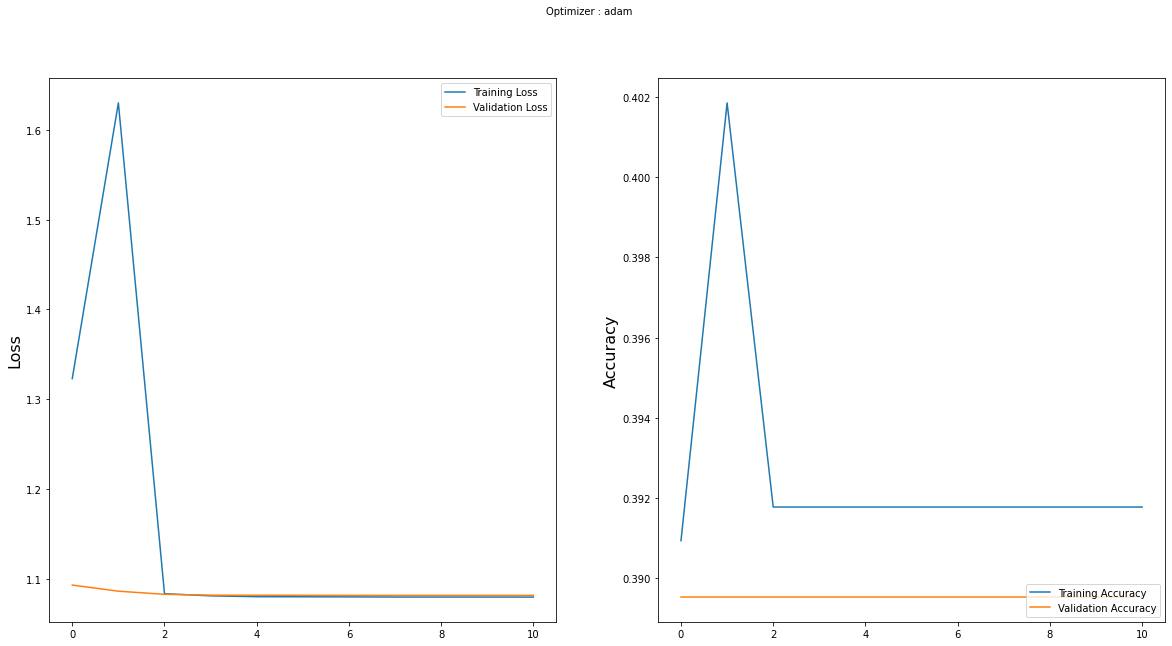

In [55]:
import matplotlib.pyplot as plt

x=hist2
plt.figure(figsize=(20,10))
plt.subplot(1, 2, 1)
plt.suptitle('Optimizer : adam', fontsize=10)
plt.ylabel('Loss', fontsize=16)
plt.plot(x.history['loss'], label='Training Loss')
plt.plot(x.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')

plt.subplot(1, 2, 2)
plt.ylabel('Accuracy', fontsize=16)
plt.plot(x.history['accuracy'], label='Training Accuracy')
plt.plot(x.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.show()

# ResNet101

In [56]:
base_model = ResNet101(input_shape = IMAGE_SIZE + [3], weights='imagenet', include_top=False)

x1= Flatten()(base_model.output)
prediction1 = Dense(3, activation='softmax')(x1)
model3 = Model(inputs = base_model.inputs, outputs = prediction1)
model3.summary()
model3.compile(loss = 'categorical_crossentropy', optimizer='adam', metrics=["accuracy",f1_m,precision_m, recall_m])


Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 134, 134, 3)  0           input_7[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 64, 64, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 64, 64, 64)   256         conv1_conv[0][0]                 
____________________________________________________________________________________________

In [57]:
hist3 = model3.fit(train_set, validation_data=test_set, epochs=25, steps_per_epoch=len(train_set), validation_steps=len(test_set),callbacks=[learning_rate_reduction, early_stop])

Epoch 1/25
596/596 [==============================] - 79s 122ms/step - loss: 2.9056 - accuracy: 0.4002 - f1_m: 0.2441 - precision_m: 0.3347 - recall_m: 0.1988 - val_loss: 1.1027 - val_accuracy: 0.2500 - val_f1_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00
Epoch 2/25
596/596 [==============================] - 71s 120ms/step - loss: 1.1286 - accuracy: 0.4077 - f1_m: 0.1885 - precision_m: 0.2802 - recall_m: 0.1426 - val_loss: 13.3610 - val_accuracy: 0.3333 - val_f1_m: 0.1169 - val_precision_m: 0.1492 - val_recall_m: 0.1008
Epoch 3/25
596/596 [==============================] - 69s 116ms/step - loss: 1.1472 - accuracy: 0.5378 - f1_m: 0.4444 - precision_m: 0.5143 - recall_m: 0.4094 - val_loss: 1.1726 - val_accuracy: 0.3915 - val_f1_m: 0.4096 - val_precision_m: 0.4651 - val_recall_m: 0.3818
Epoch 4/25
596/596 [==============================] - 70s 118ms/step - loss: 0.9231 - accuracy: 0.6653 - f1_m: 0.6404 - precision_m: 0.6728 - recall_m: 0.6242 - val_loss: 3.0064 - 

In [66]:
dl_acc = hist3.history["val_accuracy"][24] * 100
dl_prec = hist3.history["val_precision_m"][24] * 100
dl_rec = hist3.history["val_recall_m"][24] * 100
dl_f1 = hist3.history["val_f1_m"][24] * 100

storeResults('ResNet101',dl_acc,dl_prec,dl_rec,dl_f1)

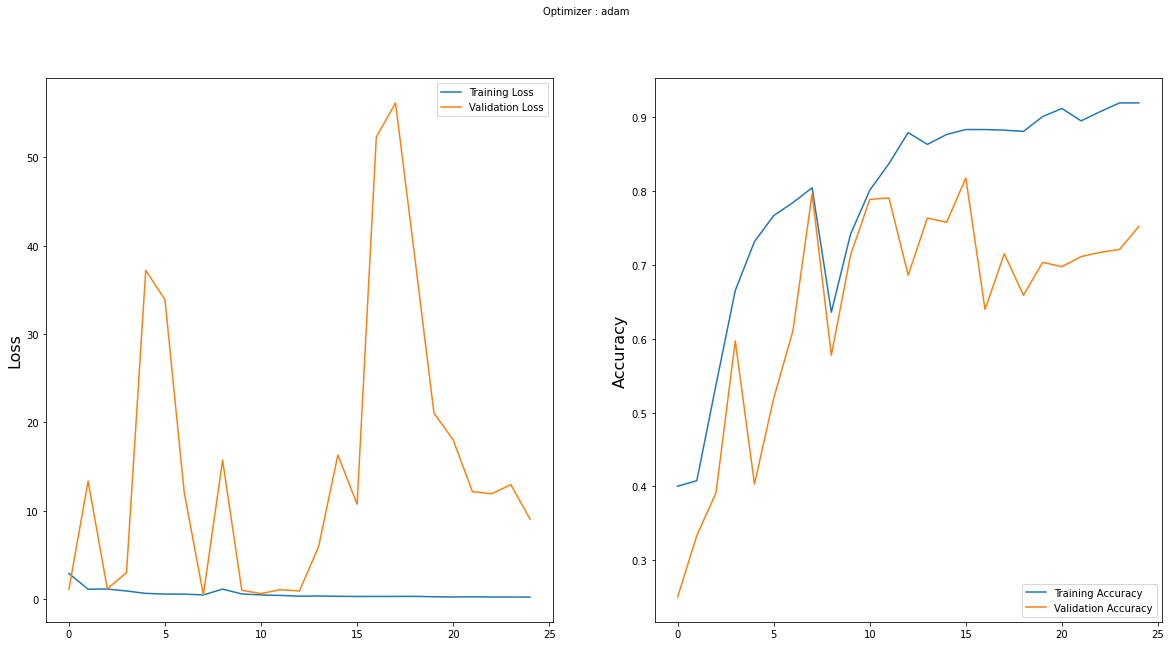

In [58]:
import matplotlib.pyplot as plt

x=hist3
plt.figure(figsize=(20,10))
plt.subplot(1, 2, 1)
plt.suptitle('Optimizer : adam', fontsize=10)
plt.ylabel('Loss', fontsize=16)
plt.plot(x.history['loss'], label='Training Loss')
plt.plot(x.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')

plt.subplot(1, 2, 2)
plt.ylabel('Accuracy', fontsize=16)
plt.plot(x.history['accuracy'], label='Training Accuracy')
plt.plot(x.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.show()

# DenseNet121

In [59]:
base_model = DenseNet121(input_shape = IMAGE_SIZE + [3], weights='imagenet', include_top=False)

x1= Flatten()(base_model.output)
prediction1 = Dense(3,activation='softmax')(x1)
model4 = Model(inputs = base_model.inputs, outputs = prediction1)
model4.summary()
model4.compile(loss = 'categorical_crossentropy', optimizer='adam', metrics=["accuracy",f1_m,precision_m, recall_m])


Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d_2 (ZeroPadding2D (None, 134, 134, 3)  0           input_8[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 64, 64, 64)   9408        zero_padding2d_2[0][0]           
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 64, 64, 64)   256         conv1/conv[0][0]                 
____________________________________________________________________________________________

In [60]:
hist4 = model4.fit(train_set, validation_data=test_set, epochs=25, steps_per_epoch=len(train_set), validation_steps=len(test_set),callbacks=[learning_rate_reduction, early_stop])

Epoch 1/25
596/596 [==============================] - 70s 108ms/step - loss: 2.9387 - accuracy: 0.6124 - f1_m: 0.6110 - precision_m: 0.6133 - recall_m: 0.6099 - val_loss: 2.8320 - val_accuracy: 0.7209 - val_f1_m: 0.7209 - val_precision_m: 0.7209 - val_recall_m: 0.7209
Epoch 2/25
596/596 [==============================] - 63s 106ms/step - loss: 1.5843 - accuracy: 0.7559 - f1_m: 0.7536 - precision_m: 0.7576 - recall_m: 0.7517 - val_loss: 1.1502 - val_accuracy: 0.7558 - val_f1_m: 0.7519 - val_precision_m: 0.7597 - val_recall_m: 0.7481
Epoch 3/25
596/596 [==============================] - 64s 108ms/step - loss: 0.8508 - accuracy: 0.8205 - f1_m: 0.8213 - precision_m: 0.8230 - recall_m: 0.8205 - val_loss: 2.3692 - val_accuracy: 0.6725 - val_f1_m: 0.6705 - val_precision_m: 0.6744 - val_recall_m: 0.6686
Epoch 4/25
596/596 [==============================] - 65s 108ms/step - loss: 0.9747 - accuracy: 0.8146 - f1_m: 0.8140 - precision_m: 0.8163 - recall_m: 0.8129 - val_loss: 0.8055 - val_accuracy:

In [67]:
dl_acc = hist4.history["val_accuracy"][24] * 100
dl_prec = hist4.history["val_precision_m"][24] * 100
dl_rec = hist4.history["val_recall_m"][24] * 100
dl_f1 = hist4.history["val_f1_m"][24] * 100

storeResults('DenseNet121',dl_acc,dl_prec,dl_rec,dl_f1)

In [36]:
model4.save('dense_multi.h5')

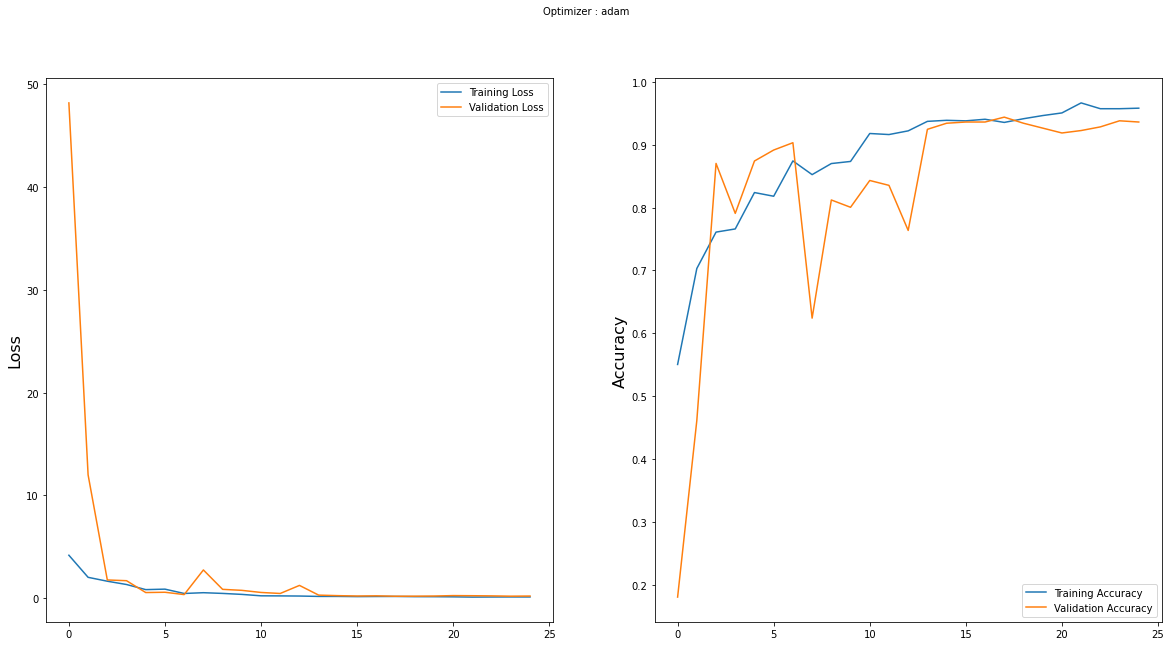

In [25]:
import matplotlib.pyplot as plt

x=hist4
plt.figure(figsize=(20,10))
plt.subplot(1, 2, 1)
plt.suptitle('Optimizer : adam', fontsize=10)
plt.ylabel('Loss', fontsize=16)
plt.plot(x.history['loss'], label='Training Loss')
plt.plot(x.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')

plt.subplot(1, 2, 2)
plt.ylabel('Accuracy', fontsize=16)
plt.plot(x.history['accuracy'], label='Training Accuracy')
plt.plot(x.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.show()

# Xception

In [26]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPool2D, GlobalAveragePooling2D, Dropout
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.optimizers import Adam

In [27]:
# Defining the pretrained base model
base = Xception(include_top=False, weights='imagenet', input_shape=(128,128,3))
x = base.output
x = GlobalAveragePooling2D()(x)
# Defining the head of the model where the prediction is conducted
head = Dense(3, activation='softmax')(x)
# Combining base and head 
model5 = Model(inputs=base.input, outputs=head)

In [28]:
model5.compile(optimizer='sgd', 
              loss = 'categorical_crossentropy', 
              metrics=["accuracy",f1_m,precision_m, recall_m])

In [29]:
model5.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 63, 63, 32)   864         input_4[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 63, 63, 32)   128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 63, 63, 32)   0           block1_conv1_bn[0][0]            
____________________________________________________________________________________________

In [33]:
hist5 = model5.fit(train_set, validation_data=test_set, epochs=25, steps_per_epoch=len(train_set), validation_steps=len(test_set),callbacks=[learning_rate_reduction, early_stop])

Epoch 1/25
596/596 [==============================] - 21s 35ms/step - loss: 0.1080 - accuracy: 0.9748 - f1_m: 0.9729 - precision_m: 0.9773 - recall_m: 0.9706 - val_loss: 0.1240 - val_accuracy: 0.9690 - val_f1_m: 0.9709 - val_precision_m: 0.9748 - val_recall_m: 0.9690
Epoch 2/25
596/596 [==============================] - 74s 124ms/step - loss: 0.0932 - accuracy: 0.9790 - f1_m: 0.9782 - precision_m: 0.9815 - recall_m: 0.9765 - val_loss: 0.1342 - val_accuracy: 0.9671 - val_f1_m: 0.9677 - val_precision_m: 0.9690 - val_recall_m: 0.9671
Epoch 3/25
596/596 [==============================] - 73s 123ms/step - loss: 0.1073 - accuracy: 0.9748 - f1_m: 0.9709 - precision_m: 0.9748 - recall_m: 0.9690 - val_loss: 0.1291 - val_accuracy: 0.9671 - val_f1_m: 0.9671 - val_precision_m: 0.9671 - val_recall_m: 0.9671
Epoch 4/25
596/596 [==============================] - 70s 118ms/step - loss: 0.1137 - accuracy: 0.9723 - f1_m: 0.9709 - precision_m: 0.9748 - recall_m: 0.9690 - val_loss: 0.1259 - val_accuracy: 

In [68]:
dl_acc = hist5.history["val_accuracy"][10] * 100
dl_prec = hist5.history["val_precision_m"][10] * 100
dl_rec = hist5.history["val_recall_m"][10] * 100
dl_f1 = hist5.history["val_f1_m"][10] * 100

storeResults('Xception',dl_acc,dl_prec,dl_rec,dl_f1)

In [37]:
model5.save('xcept_multi.h5')

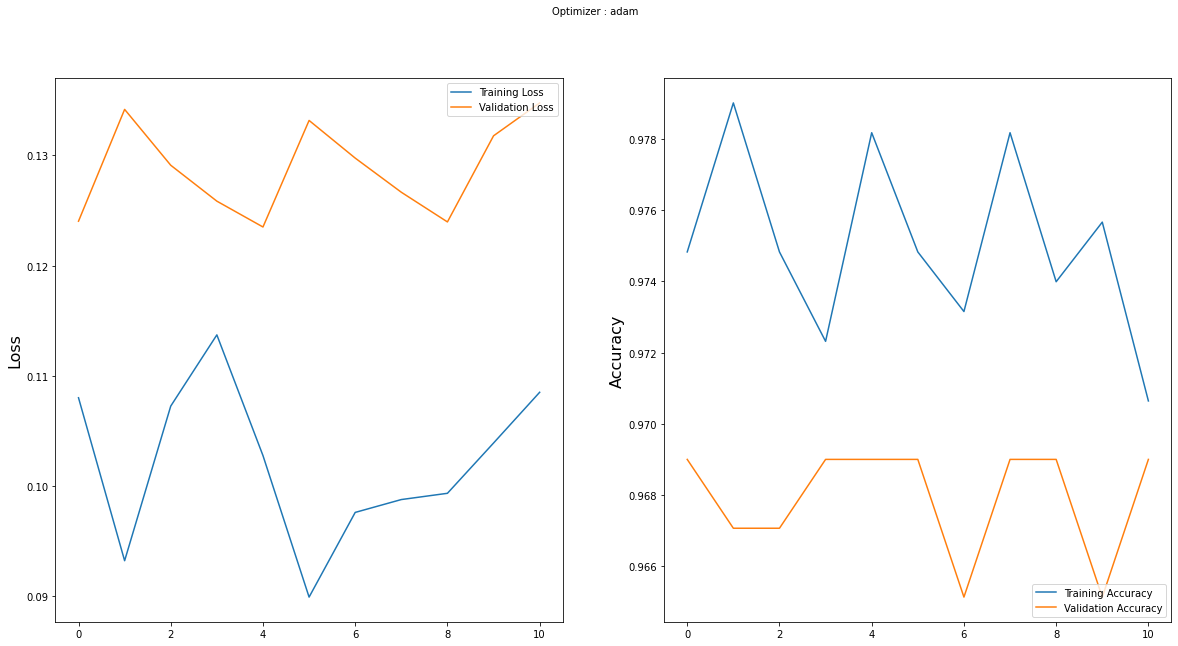

In [34]:
import matplotlib.pyplot as plt

x=hist5
plt.figure(figsize=(20,10))
plt.subplot(1, 2, 1)
plt.suptitle('Optimizer : adam', fontsize=10)
plt.ylabel('Loss', fontsize=16)
plt.plot(x.history['loss'], label='Training Loss')
plt.plot(x.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')

plt.subplot(1, 2, 2)
plt.ylabel('Accuracy', fontsize=16)
plt.plot(x.history['accuracy'], label='Training Accuracy')
plt.plot(x.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.show()

# Hybrid Model

In [38]:
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Average
import efficientnet.keras 
def ensemble():

    model_1 = load_model('xcept_multi.h5', compile=False)
    model_1 = Model(inputs = model_1.inputs, outputs = model_1.outputs, name = 'Xception')

    model_2 = load_model('dense_multi.h5', compile=False)
    model_2 = Model(inputs = model_2.inputs, outputs = model_2.outputs, name = 'DenseNet')
    
    models = [model_1, model_2]


    models_input = Input(shape =(128,128,3))
    models_output = [model(models_input) for model in models]
    
    ensemble_output = Average()(models_output)

    simple_average = Model(inputs = models_input, outputs = ensemble_output, name = 'Ensemble')

    return simple_average

In [39]:
model = ensemble()
model.compile(optimizer='sgd', 
              loss = 'categorical_crossentropy', 
              metrics=["accuracy",f1_m,precision_m, recall_m])
model.summary()

Model: "Ensemble"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
Xception (Functional)           (None, 3)            20867627    input_5[0][0]                    
__________________________________________________________________________________________________
DenseNet (Functional)           (None, 3)            7086659     input_5[0][0]                    
__________________________________________________________________________________________________
average (Average)               (None, 3)            0           Xception[0][0]                   
                                                                 DenseNet[0][0]            

In [72]:
history = model.fit(
    train_set,
    epochs=25,
    validation_data=test_set)#,callbacks=[learning_rate_reduction, early_stop])

Epoch 1/25
258/258 [==============================] - 30s 115ms/step - loss: 0.0342 - accuracy: 0.9961 - f1_m: 0.9961 - precision_m: 0.9961 - recall_m: 0.9961 - val_loss: 0.0469 - val_accuracy: 0.9922 - val_f1_m: 0.9929 - val_precision_m: 0.9942 - val_recall_m: 0.9922
Epoch 2/25
258/258 [==============================] - 29s 111ms/step - loss: 0.0411 - accuracy: 0.9961 - f1_m: 0.9961 - precision_m: 0.9961 - recall_m: 0.9961 - val_loss: 0.0488 - val_accuracy: 0.9922 - val_f1_m: 0.9929 - val_precision_m: 0.9942 - val_recall_m: 0.9922
Epoch 3/25
258/258 [==============================] - 30s 115ms/step - loss: 0.0359 - accuracy: 0.9961 - f1_m: 0.9948 - precision_m: 0.9961 - recall_m: 0.9942 - val_loss: 0.0513 - val_accuracy: 0.9922 - val_f1_m: 0.9916 - val_precision_m: 0.9942 - val_recall_m: 0.9903
Epoch 4/25
258/258 [==============================] - 30s 115ms/step - loss: 0.0364 - accuracy: 0.9922 - f1_m: 0.9922 - precision_m: 0.9922 - recall_m: 0.9922 - val_loss: 0.0499 - val_accuracy:

In [69]:
dl_acc = history.history["val_accuracy"][24] * 100
dl_prec = history.history["val_precision_m"][24] * 100
dl_rec = history.history["val_recall_m"][24] * 100
dl_f1 = history.history["val_f1_m"][24] * 100

storeResults('Hybrid Model',dl_acc,dl_prec,dl_rec,dl_f1)

In [43]:
model.save('model_multi.h5')

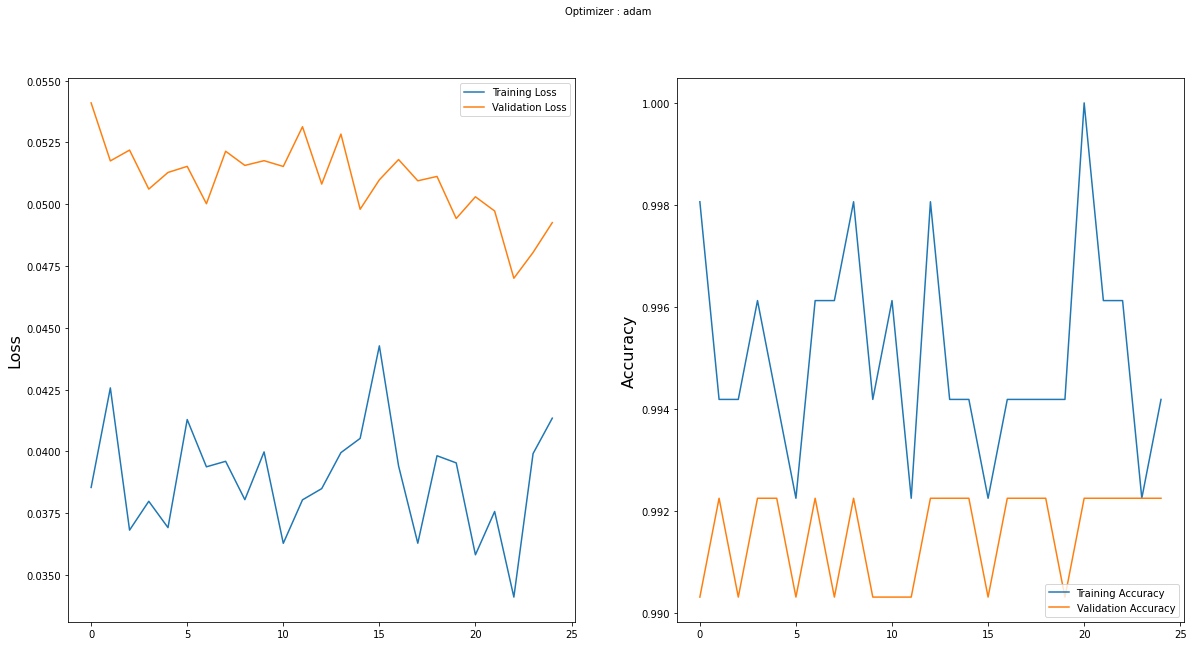

In [45]:
import matplotlib.pyplot as plt

x=history
plt.figure(figsize=(20,10))
plt.subplot(1, 2, 1)
plt.suptitle('Optimizer : adam', fontsize=10)
plt.ylabel('Loss', fontsize=16)
plt.plot(x.history['loss'], label='Training Loss')
plt.plot(x.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')

plt.subplot(1, 2, 2)
plt.ylabel('Accuracy', fontsize=16)
plt.plot(x.history['accuracy'], label='Training Accuracy')
plt.plot(x.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.show()

# Comparison

In [70]:
#creating dataframe
import pandas as pd
result = pd.DataFrame({ 'ML Model' : ML_Model,
                        'Accuracy' : accuracy,
                       'Precision': precision,
                       'Recall'   : recall, 
                       'F1_score' : f1score                        
                      })

In [71]:
result

,ML Model,Accuracy,Precision,Recall,F1_score
0,ResCapsNet,99.810,100.000,99.740,99.870
1,CNN,93.605,93.798,93.605,93.669
2,VGG19,38.953,0.000,0.000,0.000
3,ResNet101,75.194,75.775,74.612,75.000
4,DenseNet121,93.992,93.992,93.992,93.992
5,Xception,96.899,96.705,96.705,96.705
6,Hybrid Model,99.225,99.419,99.031,99.160


# Graph

In [73]:
classifier = ML_Model
y_pos = np.arange(len(classifier))

# Accuracy

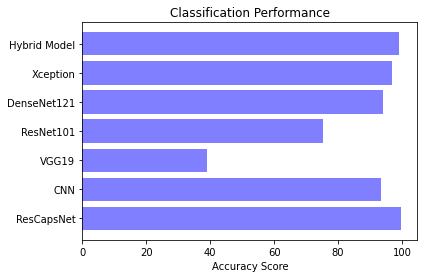

In [74]:
import matplotlib.pyplot as plt2
plt2.barh(y_pos, accuracy, align='center', alpha=0.5,color='blue')
plt2.yticks(y_pos, classifier)
plt2.xlabel('Accuracy Score')
plt2.title('Classification Performance')
plt2.show()

# Precision

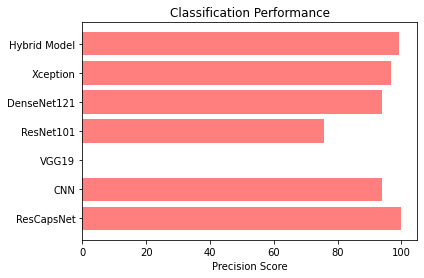

In [75]:
plt2.barh(y_pos, precision, align='center', alpha=0.5,color='red')
plt2.yticks(y_pos, classifier)
plt2.xlabel('Precision Score')
plt2.title('Classification Performance')
plt2.show()

# Recall

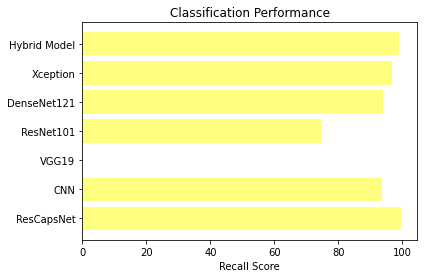

In [76]:
plt2.barh(y_pos, recall, align='center', alpha=0.5,color='yellow')
plt2.yticks(y_pos, classifier)
plt2.xlabel('Recall Score')
plt2.title('Classification Performance')
plt2.show()

# F1 Score

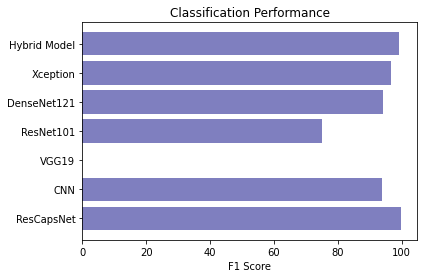

In [77]:
plt2.barh(y_pos, f1score, align='center', alpha=0.5,color='navy')
plt2.yticks(y_pos, classifier)
plt2.xlabel('F1 Score')
plt2.title('Classification Performance')
plt2.show()